#Trabajo Práctico 2 (Clustering con método K-means en Spark)
###*Conceptos y Aplicaciones en entorno Big Data 2024*
###**Alumno**: Diego Fernando Tarrío


Observaciones: cargar el archivo Sangre.txt en el directorio raíz.

DAG:






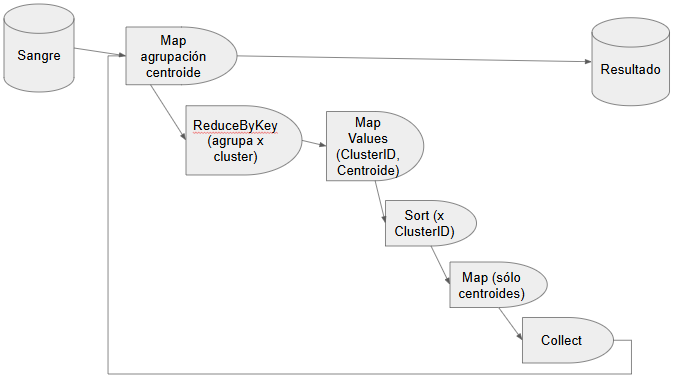

In [9]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import random
import numpy as np

# Configuro Spark
#spark = SparkSession.builder.appName("ManualKMeans").getOrCreate()
# Creamos el contexto de Spark
sc = SparkContext("local","KMeans")

In [10]:
# Cargo los datos en un RDD
root_path = "./"
archivo = root_path + 'Sangre.txt'
data = sc.textFile(archivo).map(lambda line: [float(x) for x in line.split(";")])


In [11]:
# Muestro 10 primeros registros del rdd leído
print("Primeros 10 registros del rdd leído:")
first_10_records = data.take(10)
# Imprimo los resultados
for elem in first_10_records:
    print(f"Punto: {elem}")


Primeros 10 registros del rdd leído:
Punto: [11.86513732, 6.044273433, 4.244780928, 69.30397636, 1288.148458]
Punto: [5.032462247, 1.060320255, 1.30844278, 161.1137404, 2054.458718]
Punto: [7.649795347, 11.26196917, 2.612572396, 145.3470984, 1782.111263]
Punto: [12.12930701, 5.965411411, 4.328383328, 67.71311414, 1329.331946]
Punto: [4.880297897, 1.051427861, 1.26459644, 190.7702872, 2063.219159]
Punto: [17.46651932, 21.11749668, 6.878586941, 184.6346792, 2534.649424]
Punto: [12.01083388, 6.082512631, 4.16812839, 66.81480042, 1302.539203]
Punto: [11.99532857, 5.817088492, 4.324862422, 62.06971051, 1301.060599]
Punto: [11.82661414, 6.013990285, 4.098645652, 50.59756238, 1293.026298]
Punto: [4.999426045, 0.945181394, 1.310910234, 162.5650272, 2036.414418]


In [12]:
# inicializo los centroides aleatoriamente seleccionando k puntos del conjunto de datos
k = 3  # Número de clusters
centroides = data.takeSample(False, k)

# Función para cálculo de la distancia euclídea
def distancia_euclidea(p1, p2):
    return np.sqrt(sum((x - y) ** 2 for x, y in zip(p1, p2)))

# Función que asigna a un punto el cluster más cercano
def centroide_mas_cercano(point, centroides):
    distances = [distancia_euclidea(point, centroid) for centroid in centroides]
    return distances.index(min(distances)), point


In [13]:
#imprimo los centroides seleccionados al azar
print(centroides)

[[5.129251424, 1.40808519, 1.145822133, 167.6507539, 2079.321697], [7.851132327, 10.81358403, 2.612091072, 148.9783012, 1748.359744], [1.080947763, 15.78209759, 0.492879674, 112.2322605, 1597.312187]]


In [14]:
# Realizo una cantidad fija de iteraciones de k-means (el objetivo final no era la convergencia completa del algoritmo)
cant_iteraciones = 10
for i in range(cant_iteraciones):
    # Asigno a cada punto su centroide más cercano
    clusters = data.map(lambda point: centroide_mas_cercano(point, centroides))

    # Calculo los nuevos centroides como el promedio de los puntos asignados a cada cluster

    cluster_points = clusters.map(lambda x: (x[0], (np.array(x[1]), 1)))  #transforma cada entrada para que quede de la forma (cluster_id,(np.array(point),1))
                                                                          #transformo el punto a array numpy para simplificar operaciones matemáticas
                                                                          #el 1 al final lo uso como contador que se usará para calcular el promedio del cluster

    cluster_sums = cluster_points.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  #agrupa por cluster_id, reduciendo tuplas del mismo cluster sumando de la siguiente manera:
                                                                                        #x[0] + y[0] suma las coordenadas de todos los puntos en el cluster
                                                                                        #x[1] + y[1] cuenta la cantidad de puntos en el cluster
                                                                                        #el resultado es un rdd con la siguiente estructura (cluster_id, (suma_de_puntos, cantidad_de_puntos))

    cluster_averages = cluster_sums.mapValues(lambda x: x[0] / x[1])  #genero un rdd con pares (cluster_id, centroide), donde centroide es el nuevo centro calculado para cada cluster
                                                                      #como el promedio de cada coordenada

    sorted_clusters = cluster_averages.sortByKey()  #ordeno por cluster_id para asegurar que los centroides estén en un orden consistente

    nuevos_centroides_rdd = sorted_clusters.map(lambda x: x[1])  #elimino el cluster_id, dejando sólo los centroides en una lista

    nuevos_centroides = nuevos_centroides_rdd.collect() #convierte el rdd en una lista en el nodo maestro, haciendo que nuevos_centroides sea una lista de los nuevos centroides calculados

    # Actualizo los nuevos centroides para siguiente iteración
    centroides = nuevos_centroides


# imprimo los centroides finales
print("Centroides finales:")
for idx, centroid in enumerate(centroides):
    print(f"Centroide {idx + 1}: {centroid}")


Centroides finales:
Centroide 1: [  16.97600875   21.02926685    6.78970259  204.96844717 2518.90156662]
Centroide 2: [4.55386114e+00 9.01091674e+00 1.42429436e+00 1.35160403e+02
 1.83453719e+03]
Centroide 3: [  11.99889635    5.99220438    4.20266977   63.7619485  1299.41958126]


In [15]:
# Muestro ejemplo de cómo quedaron clusterizados por este algoritmo de K-Means un subconjunto del rdd de puntos:
print("Ejemplo de cómo quedaron clusterizados:")
# Obtengo los primeros 10 registros con el punto y el cluster_id asignado
first_10_records = clusters.take(10)

# Imprimo los resultados
for cluster_id, point in first_10_records:
    print(f"Cluster ID: {cluster_id}, Punto: {point}")


Ejemplo de cómo quedaron clusterizados:
Cluster ID: 2, Punto: [11.86513732, 6.044273433, 4.244780928, 69.30397636, 1288.148458]
Cluster ID: 1, Punto: [5.032462247, 1.060320255, 1.30844278, 161.1137404, 2054.458718]
Cluster ID: 1, Punto: [7.649795347, 11.26196917, 2.612572396, 145.3470984, 1782.111263]
Cluster ID: 2, Punto: [12.12930701, 5.965411411, 4.328383328, 67.71311414, 1329.331946]
Cluster ID: 1, Punto: [4.880297897, 1.051427861, 1.26459644, 190.7702872, 2063.219159]
Cluster ID: 0, Punto: [17.46651932, 21.11749668, 6.878586941, 184.6346792, 2534.649424]
Cluster ID: 2, Punto: [12.01083388, 6.082512631, 4.16812839, 66.81480042, 1302.539203]
Cluster ID: 2, Punto: [11.99532857, 5.817088492, 4.324862422, 62.06971051, 1301.060599]
Cluster ID: 2, Punto: [11.82661414, 6.013990285, 4.098645652, 50.59756238, 1293.026298]
Cluster ID: 1, Punto: [4.999426045, 0.945181394, 1.310910234, 162.5650272, 2036.414418]


In [16]:
# cierro la sesión de Spark
sc.stop()